# NLP From Scratch: Translation with a Sequence to Sequence Network and Attention

In this project we will be teaching a neural network to translate from German to English.


This is made possible by the simple but powerful idea of the [sequence
to sequence network](https://arxiv.org/abs/1409.3215), in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.


To improve upon this model we'll use an [attention
mechanism](https://arxiv.org/abs/1409.0473), which lets the decoder
learn to focus over a specific range of the input sequence.

## Dependencies

In [3]:
# using Python 3.9
%pip install pandas torch matplotlib numpy ipython

In [4]:
from __future__ import unicode_literals, print_function, division
import os
from io import open
import unicodedata
import string
import re
import random
import time
import math
import pandas as pd

from IPython.display import Image
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


## Loading & preprocessing training data

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation. We then implement a parsing funciton that reads a csv file from the specified path, normalizes every sentence in the dataset using the normalize function, and returns a list of (german_sentence, english_sentence) pairs. If the parameter reverse is True, the order of languages in the tuple are reversed resulting in reverse translation.



In [6]:
# https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


def parse_data(path, reverse=False):

  pairs = pd.read_csv(path)
  pairs['GER'] = pairs['GER'].apply(normalize_string)
  pairs['ENG'] = pairs['ENG'].apply(normalize_string)

  if reverse:
    pairs = pairs[['ENG', 'GER']]

  return pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences and we will avoid explicit questions. Hence we will set a maximum sentence length of 10 words (that includes punctuation) and remove questions.



In [7]:
import pandas as pd

In [8]:
MAX_WORDS = 10

interrogative_words = ( "what", "why", "how", "which", "where", "when" , "who", "whose",
                        "was", "warum", "wie", "welche", "wo", "wann", "wer", "wieso")

"""
TODO: Task 1 (10 pt)

Implement the filter_pairs function so that it takes in a pd.DataFrame of language pairs and outputs another dataframe where following pairs are removed:

- those where one of both exceeds the maximal sentence length (MAX_WORDS)
- those where the pair contains any of the words defined in interrogative_words or a question mark.

Note: your method should NOT employ any explicit iteration (i.e. for loops).

"""
def filter_pairs(pairs,
                 drop_words=interrogative_words,
                 max_words=MAX_WORDS):

    # Creating a mask for pairs where neither sentence exceeds the max_words limit
    length_mask = (pairs.iloc[:, 0].str.split().str.len() <= max_words) & \
                  (pairs.iloc[:, 1].str.split().str.len() <= max_words)

    # Creating a regex pattern for the interrogative words and question marks
    pattern = '|'.join(drop_words) + r'|\?'

    # Creating a mask to exclude pairs containing interrogative words or question mark
    interrogative_mask = ~(pairs.iloc[:, 0].str.contains(pattern) |
                           pairs.iloc[:, 1].str.contains(pattern))

    # Applying both masks and return the filtered DataFrame
    return pairs[length_mask & interrogative_mask]




Each word in a language will be represented as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Language`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` which will be used to replace rare words later.




In [9]:
SOS_token = 0
EOS_token = 1

"""
TODO: Task 2 (10 pt)

Implement the function remove_rare_words, that removes words whose frequency is below
min_freq and makes sure that the size of the vocabulary is below max_vocab_size
by iteratively removing least frequent words.

The function should also update the indices in the dictionary, so that no index
is left unused (i.e. all values from 0 to n_words are indices) and all variables are up-to-date.

You might want to define a helper method remove_word to break down the task.

"""


class Language:
    def __init__(self):
        self.word2index = {} # maps word to integer index
        self.word2count = {} # maps word to its frequency
        self.index2word = {0: "SOS", 1: "EOS"} # maps index to a word
        self.n_words = 2  # Count SOS and EOS

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    # Defining a helper method as suggested in the question to remove the words and update the index
    def remove_word(self, word):
        if word in self.word2index:
            # Remove word from word2index and word2count
            del self.word2index[word]
            del self.word2count[word]

            # Rebuild index2word
            self.index2word = {0: "SOS", 1: "EOS"}
            for w in self.word2index:
                self.index2word[self.word2index[w]] = w

    def remove_rare_words(self, min_freq, max_vocab_size):
        # Remove words with frequency below min_freq
        for word, count in list(self.word2count.items()):
            if count < min_freq:
                self.remove_word(word)

        # If vocab size exceeds max_vocab_size, remove least frequent words
        while len(self.word2index) > max_vocab_size:
            # Find the least frequent word
            least_freq_word = min(self.word2count, key=self.word2count.get)
            self.remove_word(least_freq_word)

        # Update n_words (view this later)
        self.n_words = len(self.word2index)


The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [10]:
def prepare_data(pairs, reverse=False):

    print(f"Read {len(pairs)} sentence pairs")
    pairs = filter_pairs(pairs)
    print(f"Filtered {len(pairs)} sentence pairs")
    pairs = pairs.to_numpy()

    input_lang = Language()
    output_lang = Language()

    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])

    print(f"Input language: {input_lang.n_words} words")
    print(f"Output language: {output_lang.n_words} words")
    return input_lang, output_lang, pairs



In [11]:
#path = os.path.join(os.getcwd(), "data", "translations.csv")

#changing this slightly since I'm working in Google Colab
path = "https://raw.githubusercontent.com/Hertie-School-Deep-Learning-Fall-2023/problem-set-3-ps3_group_g/main/data/translations.csv"
pairs = parse_data(path)
input_lang, output_lang, pairs = prepare_data(pairs, reverse=True)
### SHOW NOTEBOOK OUTPUT ###

Read 255817 sentence pairs
Filtered 131442 sentence pairs
Input language: 12521 words
Output language: 24253 words


## Encoder-decoders

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A [Sequence to Sequence network](https://arxiv.org/abs/1409.3215)_, or
seq2seq network, or [Encoder Decoder
network](https://arxiv.org/pdf/1406.1078v3.pdf)_, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages, because there usally is not a 1:1 mapping between words.


### The Encoder

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

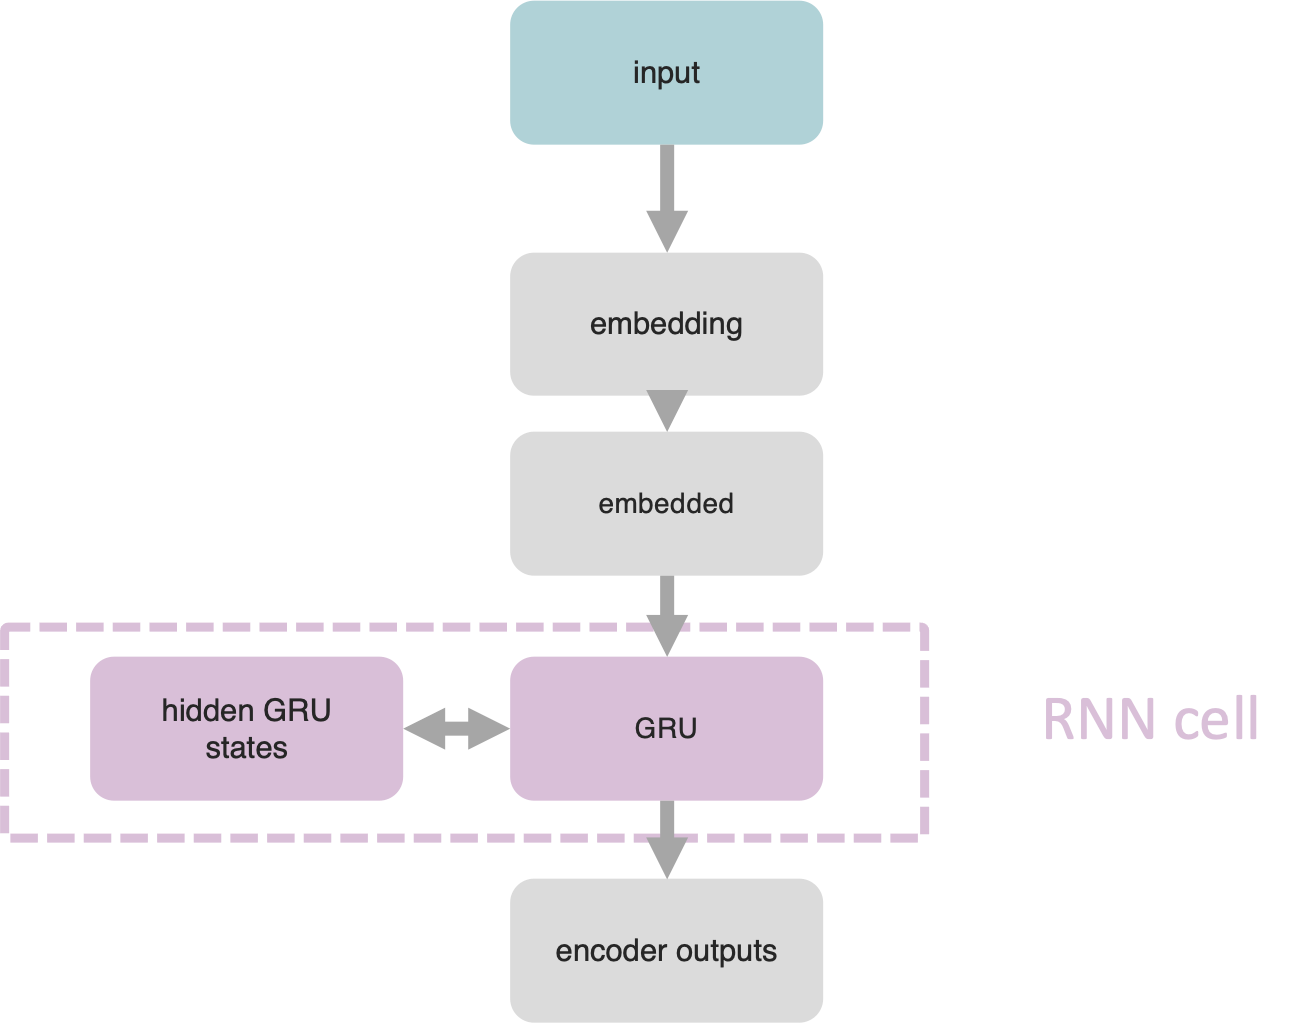

In [12]:
from PIL import Image
import requests
url = 'https://raw.githubusercontent.com/Hertie-School-Deep-Learning-Fall-2023/problem-set-3-ps3_group_g/main/img/encoder.png'
im = Image.open(requests.get(url, stream=True).raw)
im

In [13]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, rnn_type='GRU', batch_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.rnn_type = rnn_type

        self.embedding = nn.Embedding(input_size, hidden_size) #produces a list of vect
        self.rnn = getattr(nn, rnn_type)(self.hidden_size, self.hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1) # translates input (series of indices for the respective words) into their vector representation
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=device)

Although all encoders must have certain distinctive features to be called as such, as for example the ability to process sequences of different length returning fixed-length hidden states, it is not required for them to have a recurrent structure. In fact, most state-of-the art NLP models use transformer layers, combining attention layers with feed-forward network for a higher parallelizability. Because transformer layers process information in parallel, they have no inherent mechanisms that makes them aware of the position of the word in the sentence and need to engineer a feature that encodes that information.

In [14]:
"""
TODO: Task 3 (10 pt)

Implement a positional encoding module for an alternative encoder using transformers.
The positional encoder should create a vector of size max_length containing the
discrete values of a function f(x) applied on the even features of the input
and g(x) applied on the odd features of the input.
f(x) should be defaulted to sine, g(x) to cosine.
Their value should be scaled by div_term.

Briefly describe (3-4 sentences):

- why sinusoidal are used by default
- how div_term impacts the encoding
- which characteristics would make a function a suitable
  alternative to sinusoidals.

Note: you are not expected to train the TransformerEncoder (this will most likely
not work due to incompatibility with the train method). Simply show you can initialize
the encoder and pass a tensor through it.

Why Sinusoidal Functions are Often Used:
We usually use sine and cosine functions for positional encoding because they're good at giving each word position a unique pattern. This helps the model to figure out where each word is in a sentence. Plus, these functions have a repeating cycle, so the model can learn about the order of words relative to each other.
How div_term Affects the Encoding:
The div_term in the formula makes the wave of the sine and cosine functions longer or shorter. This helps the model to not get too confused by making sure the position information isn't too squished or stretched out. It's like adjusting the zoom on a camera to get a clearer picture.
What Would Make a Good Alternative to Sinusoidals:
If we're not using sine and cosine functions, we still need something that gives each position a special pattern so the model can tell them apart. A good alternative should help the model see the difference between positions and understand the order of words. It should have a regular pattern, like how every day follows the night, to help the model predict and learn better.


"""


class PositionalEncoding(nn.Module):
    def __init__(self, hidden_size, max_length, even_fc=torch.sin, odd_fc=torch.cos):
        super(PositionalEncoding, self).__init__()
        self.hidden_size = hidden_size

        # Create a positional encoding matrix of size (max_length, hidden_size)
        position = torch.arange(max_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_size, 2).float() * (-math.log(10000.0) / hidden_size))

        pe = torch.zeros(max_length, hidden_size)
        pe[:, 0::2] = even_fc(position.float() * div_term)
        pe[:, 1::2] = odd_fc(position.float() * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return x

class TransformerEncoder(nn.Module):

    def __init__(self, input_size, hidden_size, max_length=MAX_WORDS, batch_size=1):

        super().__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.positional_encoding = PositionalEncoding(hidden_size, max_length)
        self.transformer_layers = nn.TransformerEncoderLayer(hidden_size, nhead=4)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layers, num_layers=6)
        self.fc = nn.Linear(hidden_size, hidden_size)

    def forward(self, input, positional_encoding=False):


        embedded = self.embedding(input) # translates input (series of indices for the respective words) into their vector representation

        # If true, applies positional encoding
        if positional_encoding:
            embedded = self.positional_encoding(embedded).view(1, 1, -1)

        # Transformer encoder layers
        transformer_output = self.transformer_encoder(embedded)

        # Fully connected layer
        output = self.fc(transformer_output)

        return output

def tensorFromSentence(lang, sentence):
    indexes = [lang.word2index[word] for word in sentence.split(' ')]
    indexes.append(EOS_token) # Append the EOS token
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

In [15]:
attn_encoder = TransformerEncoder(input_lang.n_words, 256)
input = tensorFromSentence(input_lang, pairs[0][0])
attn_encoder(input)
### SHOW NOTEBOOK OUTPUT ###

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


tensor([[[ 0.0899, -0.0192,  0.1785, -0.3771, -0.3685,  0.1219,  0.8854,
           0.4681,  0.7331,  0.6986, -0.0752,  0.0400, -0.0086,  0.2150,
           0.0988, -0.0988, -0.8418, -0.5793, -0.0389, -0.0191, -0.0502,
          -1.0407, -0.1225, -0.4937,  0.1865,  0.4355, -0.1942,  0.4886,
          -0.5888, -0.7041, -0.2997,  0.1295, -0.5818,  0.2352, -0.0978,
           0.1999, -0.0867,  0.4909,  0.3370,  0.4541,  0.2744, -0.0670,
           0.6240,  0.0923, -0.3029, -0.3661, -0.1850,  0.0633,  0.8237,
           0.3813, -0.3206, -0.0595, -0.3759, -0.4157, -0.3368, -0.5355,
           0.8508,  0.1108, -0.6886,  0.5433, -0.5056, -1.0668,  0.8625,
           0.1300, -0.3068, -0.0123,  0.1617,  0.2137, -0.7817,  0.3143,
           0.0212, -0.3874, -0.7394,  0.1785,  0.4611, -0.4137,  0.7325,
           0.4428, -0.7137, -0.7961, -0.3046,  0.0754, -0.1152,  0.5752,
          -0.4133, -0.3086,  0.0812, -1.0749, -0.4434, -0.6328,  0.4144,
           0.5802,  0.6436, -0.3659, -0.7185,  0.02

### The Decoder

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




#### Attention Decoder


Attention allows the decoder network to "focus" on a different part of the encoder's outputs for every step of the decoder's own outputs.
For this, we determine a set of attention weights which capture which part of the sentence is most important for the translation.
The attention weights will be multiplied by the encoder output vectors to create a weighted combination.
The result should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

Specifically, this is done as follows:
1. Attention weights are calculated with a feed-forward layer (`self.attn`) using the concatenated decoder's input and hidden state as inputs and appying a softmax to it.
   * Because there are sentences of all sizes in the training data, to actually create and train this layer we have to choose a maximum sentence length (input length, for encoder outputs) that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.
1. The attention weights will be multiplied by the encoder output vectors to create a weighted combination (using `torch.bmm()`).
1. The encoder outputs weighted by the attention weights are concatenated (use `torch.cat`) with the decoder's embeddings and fed into another feed-forward layer (`self.attn_combine`).
1. ReLu is applied on the output of the attention module.



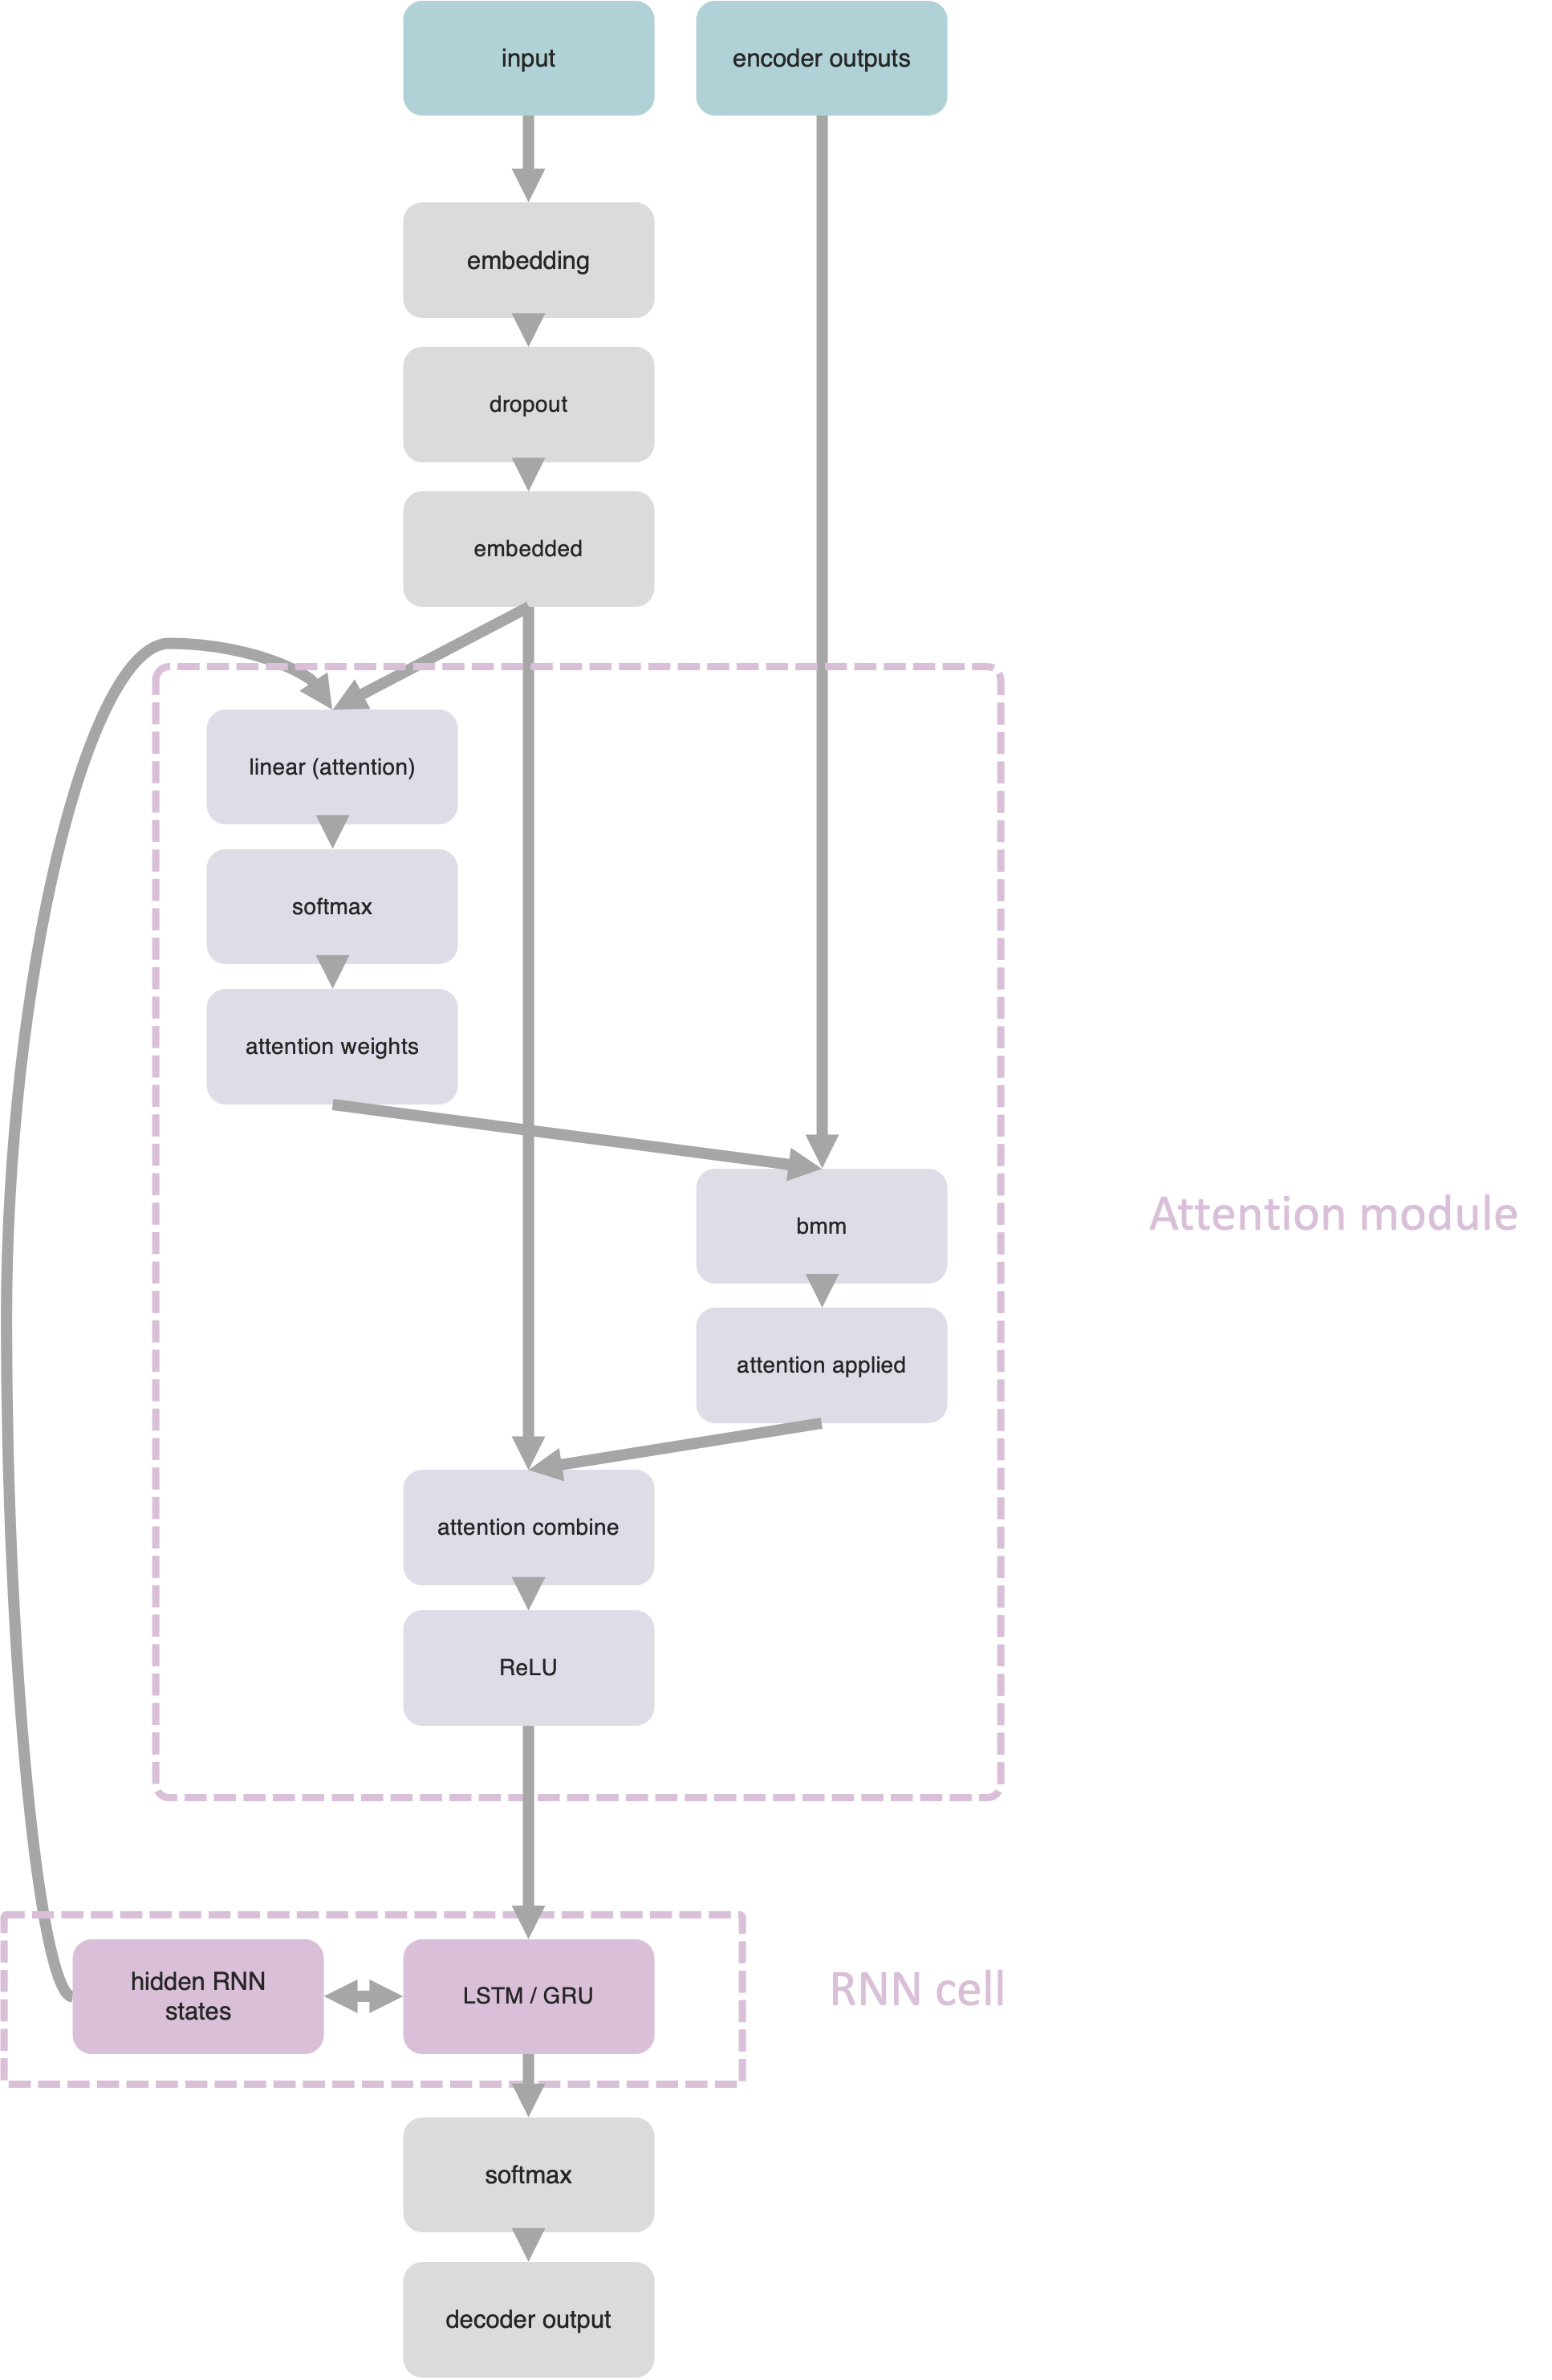

In [16]:
#Image(filename="img/decoder.png", height=900)

#changing this slightly since I'm in Google Colab
#Image(filename="decoder.png", height=900)

url = 'https://raw.githubusercontent.com/Hertie-School-Deep-Learning-Fall-2023/problem-set-3-ps3_group_g/main/img/decoder.png'
im = Image.open(requests.get(url, stream=True).raw)
im

In [17]:
"""
TODO: Task 4 (10 pt)
Implement the attention layer as described above and depicted in the figure.

Show the train progress (3-5 min) when using the decoder with attention on the translation task (see "Pre-trained GRU seq2seq model" section below).

"""

class Attention(nn.Module):
    def __init__(self, hidden_size, max_length):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.max_length = max_length

        # Define layers for the attention mechanism
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()

    def forward(self, embedded, hidden, encoder_outputs):
        # Concatenate embedded input word and hidden state
        combined = torch.cat((embedded[0], hidden[0]), 1)

        # Attention weights
        attn_weights = self.softmax(self.attn(combined))

        # Apply attention weights to encoder outputs
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        # Combine attention applied outputs with embedded input word
        output = self.attn_combine(torch.cat((attn_applied[0], embedded[0]), 1)).unsqueeze(0)
        output = self.tanh(output)

        return output




In [18]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, rnn_type='GRU', rnn_n_layers=1, batch_size=1, max_length=MAX_WORDS+1):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.rnn_type = rnn_type
        self.rnn_n_layers = rnn_n_layers
        self.batch_size = batch_size

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.attention = Attention(self.hidden_size, self.max_length)
        self.rnn = getattr(nn, self.rnn_type)(self.hidden_size, self.hidden_size, self.rnn_n_layers)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        c0 = self.init_hidden()
        # h0 = self.init_hidden() # reuse hidden state of LSTM/GRU cell or reinitialize?

        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        if self.rnn_type == 'LSTM':
            attn_hidden = hidden[0] # only hidden, not cell state
        else:
            attn_hidden = hidden # GRU has no cell state

        output = self.attention(embedded, attn_hidden, encoder_outputs)
        output, hidden = self.rnn(output, hidden)
        output = self.out(output[0])
        output = F.log_softmax(output, dim=1)

        return output, hidden

    def init_hidden(self):
        weights = torch.zeros(self.rnn_n_layers, self.batch_size, self.hidden_size, device=device)
        return (weights, weights) if self.rnn_type == 'LSTM' else weights


# Training

### Preparing Training Data

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [19]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### Training the Model

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the `<SOS>` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but [when the trained
network is exploited, it may exhibit
instability](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf).

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [20]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_WORDS+1):
    encoder_hidden = encoder.init_hidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [21]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

### Plotting results

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [22]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    return fig

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [23]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

## Evaluation

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [24]:
def evaluate(encoder, decoder, sentence, max_length=MAX_WORDS+1):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.init_hidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [25]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Training and Evaluating

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. When training from scratch after about 40 minutes on a MacBook CPU we'll get some
reasonable results.

To speed-up the training, we do not randomly initialize the weights, but reuse the weights from a pretrained model.

Note: run this cells to show that your code is correctly functioning.



In [26]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [27]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size, rnn_type='GRU').to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, rnn_type='GRU', batch_size=1, dropout_p=0.1).to(device)

In [28]:
trainIters(encoder, attn_decoder, 10**3, print_every=100)
### SHOW NOTEBOOK OUTPUT ###

0m 10s (- 1m 32s) (100 10%) 7.0688
0m 19s (- 1m 17s) (200 20%) 5.8740
0m 26s (- 1m 2s) (300 30%) 5.6860
0m 31s (- 0m 47s) (400 40%) 5.3276
0m 35s (- 0m 35s) (500 50%) 5.3064
0m 39s (- 0m 26s) (600 60%) 5.0457
0m 43s (- 0m 18s) (700 70%) 5.3846
0m 46s (- 0m 11s) (800 80%) 5.1263
0m 50s (- 0m 5s) (900 90%) 5.2114
0m 54s (- 0m 0s) (1000 100%) 5.1655


In [29]:
evaluateRandomly(encoder, attn_decoder)
### SHOW NOTEBOOK OUTPUT ###

> you can t just quit .
= du kannst nicht einfach aufhoren .
< ich will das . . <EOS>

> tom congratulated mary on her graduation .
= tom begluckwunschte mary zu ihrem abschluss .
< ich will das nicht . <EOS>

> i need to go now .
= ich muss jetzt gehen .
< ich will das . . <EOS>

> i m game .
= ich mache mit .
< ich ist . <EOS>

> i don t think you should eat that .
= ich finde sie sollten das nicht essen .
< ich will das nicht . . <EOS>

> tom scolded mary .
= tom schalt mary .
< tom ist . <EOS>

> tom has a bad headache .
= tom hat starke kopfschmerzen .
< ich will nicht . . <EOS>

> i appreciate your telling me .
= danke dass du mir das gesagt hast !
< ich will das . . <EOS>

> it rained for hours and hours .
= es regnete stundenlang .
< ich will das nicht . <EOS>

> the ball hit her in the eye .
= der ball traf sie ins auge .
< ich will das nicht . . <EOS>



#### Pre-trained GRU seq2seq model

Load the state dict including the weights of a pre-trained model. If the initialization does not work, the architecture of your decoder is likely incorrect. Keep in mind that the two feed-forward layers of the Attention module have to be named `attn` and `attn_combine`.

In [30]:
# Set up the encoder with adjusted embedding layer
hidden_size = 256
encoder_model_file = "https://github.com/Hertie-School-Deep-Learning-Fall-2023/problem-set-3-ps3_group_g/raw/main/data/pretrained_encoder2.pt"
adjusted_encoder_vocab_size = input_lang.n_words  # This matches your dataset's vocabulary size

# Initialize the pre-trained encoder
encoder_to_adjust = EncoderRNN(adjusted_encoder_vocab_size, hidden_size, rnn_type='GRU').to(device)

# Check and adjust the size of the embedding layer
if encoder_to_adjust.embedding.weight.shape[0] != adjusted_encoder_vocab_size:
    adjusted_embedding_layer = nn.Embedding(adjusted_encoder_vocab_size, hidden_size).to(device)
    encoder_to_adjust.embedding = adjusted_embedding_layer

# Clone the pre-trained encoder to use in your model
final_encoder = EncoderRNN(adjusted_encoder_vocab_size, hidden_size, rnn_type='GRU').to(device)
final_encoder.load_state_dict(encoder_to_adjust.state_dict(), strict=False)
final_encoder.eval()

# The final_encoder is now ready for use with your dataset


EncoderRNN(
  (embedding): Embedding(12521, 256)
  (rnn): GRU(256, 256)
)

In [31]:
# Set up the attention decoder with adjusted embedding layer
hidden_size = 256
decoder_model_file = "https://github.com/Hertie-School-Deep-Learning-Fall-2023/problem-set-3-ps3_group_g/raw/main/data/pretrained_decoder2.pt"
adjusted_decoder_vocab_size = 24253  # This matches your dataset's vocabulary size

# Initialize the pre-trained attention decoder
decoder_to_adjust = AttnDecoderRNN(hidden_size, output_lang.n_words, rnn_type='GRU', dropout_p=0.1).to(device)

# Check and adjust the size of the embedding layer
if decoder_to_adjust.embedding.weight.shape[0] != adjusted_decoder_vocab_size:
    adjusted_embedding_layer = nn.Embedding(adjusted_decoder_vocab_size, hidden_size).to(device)
    decoder_to_adjust.embedding = adjusted_embedding_layer

# Clone the pre-trained decoder to use in your model
final_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, rnn_type='GRU', dropout_p=0.1).to(device)
final_decoder.load_state_dict(decoder_to_adjust.state_dict(), strict=False)
final_decoder.eval()

# The final_decoder is now ready for use with your dataset


AttnDecoderRNN(
  (embedding): Embedding(24253, 256)
  (dropout): Dropout(p=0.1, inplace=False)
  (attention): Attention(
    (attn): Linear(in_features=512, out_features=11, bias=True)
    (attn_combine): Linear(in_features=512, out_features=256, bias=True)
    (softmax): Softmax(dim=1)
    (tanh): Tanh()
  )
  (rnn): GRU(256, 256)
  (out): Linear(in_features=256, out_features=24253, bias=True)
)

In [32]:
# Ensure both encoder and decoder are in training mode
final_encoder.train()
final_decoder.train()

AttnDecoderRNN(
  (embedding): Embedding(24253, 256)
  (dropout): Dropout(p=0.1, inplace=False)
  (attention): Attention(
    (attn): Linear(in_features=512, out_features=11, bias=True)
    (attn_combine): Linear(in_features=512, out_features=256, bias=True)
    (softmax): Softmax(dim=1)
    (tanh): Tanh()
  )
  (rnn): GRU(256, 256)
  (out): Linear(in_features=256, out_features=24253, bias=True)
)

In [33]:
trainIters(final_encoder, final_decoder, 10**3, print_every=100)
### SHOW NOTEBOOK OUTPUT ###

0m 3s (- 0m 30s) (100 10%) 7.0414
0m 9s (- 0m 36s) (200 20%) 5.9530
0m 14s (- 0m 34s) (300 30%) 5.2693
0m 18s (- 0m 27s) (400 40%) 5.3565
0m 21s (- 0m 21s) (500 50%) 5.3572
0m 25s (- 0m 16s) (600 60%) 5.3472
0m 28s (- 0m 12s) (700 70%) 5.3191
0m 32s (- 0m 8s) (800 80%) 5.2340
0m 36s (- 0m 4s) (900 90%) 5.3109
0m 40s (- 0m 0s) (1000 100%) 4.9781


In [34]:
evaluateRandomly(final_encoder, final_decoder)
### SHOW NOTEBOOK OUTPUT ###

> we re changing our clothes .
= wir ziehen uns um .
< ich hat nicht . . <EOS>

> i just want to help .
= ich will nur helfen .
< ich hat nicht . . <EOS>

> tom should thank me .
= tom sollte mir dankbar sein .
< ich hat nicht . . <EOS>

> all brides are beautiful on their wedding days .
= am tage ihrer hochzeit sind alle braute schon .
< ich hat nicht . . <EOS>

> in theory it s possible .
= theoretisch ist es moglich .
< ich hat nicht . . <EOS>

> i hope that s a joke .
= ich hoffe das ist ein scherz .
< ich hat nicht . . <EOS>

> we miss you very much .
= wir vermissen dich sehr .
< ich hat nicht . . <EOS>

> that child wants some friends to play with .
= dieses kind mochte freunde die mit ihm spielen .
< ich hat nicht . . <EOS>

> i hate boston .
= ich hasse boston .
< ich habe nicht . . <EOS>

> she asked us to be quiet .
= sie bat uns still zu sein .
< ich hat nicht . . <EOS>



# Transfer learning
## Fine tune out-of-the box encoder-decoder model

In [35]:
"""
TODO: Task 5 (10 pt)

Load a transformer for the hugging face library and fine-tune it to your problem.
Show the training progress of the model and the training metrics. Briefly
explain (3-4 sentences) the model choice and comment on the outcomes.

Note: you don't have to use the above-defined methods for training.
Splitting the dataset in train and test is welcomed, but not required for the task.

"""



"\nTODO: Task 5 (10 pt)\n\nLoad a transformer for the hugging face library and fine-tune it to your problem.\nShow the training progress of the model and the training metrics. Briefly\nexplain (3-4 sentences) the model choice and comment on the outcomes.\n\nNote: you don't have to use the above-defined methods for training.\nSplitting the dataset in train and test is welcomed, but not required for the task.\n\n"

In [36]:
from transformers import MarianMTModel, MarianTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader

In [37]:
name = 'Helsinki-NLP/opus-mt-en-de'
model = MarianMTModel.from_pretrained(name)
tokenizer = MarianTokenizer.from_pretrained(name)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [38]:
english_words = [pair[0] for pair in pairs]
tokens = tokenizer(english_words, return_tensors="pt", padding=True)

In [39]:
labels = tokenizer([pair[1] for pair in pairs], return_tensors="pt", padding=True)["input_ids"]


In [40]:
train_dataset = torch.utils.data.TensorDataset(tokens["input_ids"],
                                               tokens["attention_mask"],
                                               labels)


In [41]:
#use a smaller sample size
train_dataset = torch.utils.data.Subset(train_dataset, range(0, 8000))
train_loader = DataLoader(train_dataset, batch_size=4)
val_dataset = torch.utils.data.Subset(train_dataset, range(len(train_dataset) - 500, len(train_dataset)))
val_loader = DataLoader(val_dataset, batch_size=4)
len(train_dataset), len(val_dataset)

(8000, 500)

In [42]:
#making sure everything is in the same place
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [43]:
#takes 8 min
num_epochs = 5
learning_rate = 5e-5
accumulation_steps = 4
optimizer = AdamW(model.parameters(), lr=learning_rate)
effective_training_steps = len(train_loader) * num_epochs // accumulation_steps
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=effective_training_steps)

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, batch in enumerate(train_loader, 1):
        # Unpack the batch
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass
        loss.backward()

        if i % accumulation_steps == 0 or i == len(train_loader):
            # Update model parameters after accumulating gradients
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item()

        if i % 100 == 0:  # Print every 100 batches
            print(f"Epoch: {epoch + 1}, Batch: {i}/{len(train_loader)}, Loss: {loss.item():.4f}")

    average_loss = running_loss / len(train_loader) / accumulation_steps

    print(f"Epoch: {epoch + 1}, Average Loss: {average_loss:.4f}")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 1, Batch: 100/2000, Loss: 1.2946
Epoch: 1, Batch: 200/2000, Loss: 0.5653
Epoch: 1, Batch: 300/2000, Loss: 0.6174
Epoch: 1, Batch: 400/2000, Loss: 0.8479
Epoch: 1, Batch: 500/2000, Loss: 0.4250
Epoch: 1, Batch: 600/2000, Loss: 0.5587
Epoch: 1, Batch: 700/2000, Loss: 0.4000
Epoch: 1, Batch: 800/2000, Loss: 0.5475
Epoch: 1, Batch: 900/2000, Loss: 0.3312
Epoch: 1, Batch: 1000/2000, Loss: 0.1480
Epoch: 1, Batch: 1100/2000, Loss: 0.2729
Epoch: 1, Batch: 1200/2000, Loss: 0.1170
Epoch: 1, Batch: 1300/2000, Loss: 0.6351
Epoch: 1, Batch: 1400/2000, Loss: 0.5169
Epoch: 1, Batch: 1500/2000, Loss: 0.5324
Epoch: 1, Batch: 1600/2000, Loss: 0.1836
Epoch: 1, Batch: 1700/2000, Loss: 0.4473
Epoch: 1, Batch: 1800/2000, Loss: 0.1713
Epoch: 1, Batch: 1900/2000, Loss: 0.7591
Epoch: 1, Batch: 2000/2000, Loss: 0.4986
Epoch: 1, Average Loss: 0.1245
Epoch: 2, Batch: 100/2000, Loss: 0.4781
Epoch: 2, Batch: 200/2000, Loss: 0.1595
Epoch: 2, Batch: 300/2000, Loss: 0.2746
Epoch: 2, Batch: 400/2000, Loss: 0.332

In [44]:
model.eval()

total_val_loss = 0.0
num_val_batches = len(val_loader)

for i, batch in enumerate(val_loader, 1):
    # Unpack the batch
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

    total_val_loss += loss.item()

    print(f"Batch: {i}/{len(val_loader)}, Loss: {loss.item():.4f}")

average_val_loss = total_val_loss / num_val_batches

print(f"Average Validation Loss: {average_val_loss:.4f}")

Batch: 1/125, Loss: 0.0187
Batch: 2/125, Loss: 0.0394
Batch: 3/125, Loss: 0.0147
Batch: 4/125, Loss: 0.0150
Batch: 5/125, Loss: 0.0536
Batch: 6/125, Loss: 0.0430
Batch: 7/125, Loss: 0.0368
Batch: 8/125, Loss: 0.0246
Batch: 9/125, Loss: 0.0133
Batch: 10/125, Loss: 0.0281
Batch: 11/125, Loss: 0.0292
Batch: 12/125, Loss: 0.0121
Batch: 13/125, Loss: 0.0466
Batch: 14/125, Loss: 0.1170
Batch: 15/125, Loss: 0.1303
Batch: 16/125, Loss: 0.0442
Batch: 17/125, Loss: 0.0349
Batch: 18/125, Loss: 0.0453
Batch: 19/125, Loss: 0.0372
Batch: 20/125, Loss: 0.0820
Batch: 21/125, Loss: 0.0673
Batch: 22/125, Loss: 0.0316
Batch: 23/125, Loss: 0.0170
Batch: 24/125, Loss: 0.0976
Batch: 25/125, Loss: 0.1721
Batch: 26/125, Loss: 0.0184
Batch: 27/125, Loss: 0.0578
Batch: 28/125, Loss: 0.0165
Batch: 29/125, Loss: 0.0203
Batch: 30/125, Loss: 0.1227
Batch: 31/125, Loss: 0.0490
Batch: 32/125, Loss: 0.0110
Batch: 33/125, Loss: 0.0491
Batch: 34/125, Loss: 0.0973
Batch: 35/125, Loss: 0.1172
Batch: 36/125, Loss: 0.0329
B

In [45]:
# evaluate the model randomly

def evaluateRandomly(model, n=10):
    model.eval()  # Set the model to evaluation mode
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        tokenized_input = tokenizer(pair[0], return_tensors="pt", padding=True)
        tokenized_input = {k: v.to(device) for k, v in tokenized_input.items()}  # Move to the same device
        output_words = model.generate(**tokenized_input)
        output_sentence = tokenizer.decode(output_words[0], skip_special_tokens=True)
        print('<', output_sentence)
        print('')

evaluateRandomly(model)

> it s still light out .
= drau en ist es noch hell .
< er ist immer noch hell.

> tom declined mary s invitation .
= tom lehnte marias einladung ab .
< tom lehnte die einladung marias ab.

> i can t tell you much yet .
= ich kann ihnen noch nicht viel sagen .
< ich kann dich noch nicht mehr sag.

> she came last .
= sie kam als letzte .
< sie wurde letzte.

> tom seldom makes mistakes .
= tom macht selten fehler .
< tom macht selten falsche.

> tom knows .
= tom wei es .
< tom wei es.

> i think you re mistaken .
= ich denke du irrst dich .
< ich glaube du hasst dich.

> i hope you become famous .
= ich hoffe du wirst beruhmt .
< ich hoffe dass du beruhmt wirkst.

> nothing changes .
= nichts andert sich .
< nichts verandert sich.

> mary died during childbirth .
= maria starb bei der geburts ihres kindes .
< maria ist während der geburt gestorben.



The Helsinki-NLP MarianMTModel is trained for machine translation, in this particular case it is specifically trained for English to German translation. Trained on a large dataset, it has a nice understanding of the translation flow.

The model is not perfect but has decent values in the loss functions observed. The highest value of loss was 0.19, but usually most are under 0.10.

# Credits

This problem set is based upon an official PyTorch [tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). Many thanks to PyTorch, [Sean Robertson](https://github.com/spro/practical-pytorch) and  [Florian Nachtigall](https://github.com/FlorianNachtigall).

Be cautious with looking in the original notebook for answers. Many details have been changed and you won't be able to copy-and-paste solutions.
